In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Flatten, LeakyReLU, Reshape, Activation
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import EarlyStopping
from keras import backend as K
from IPython import display

train_df = pd.read_csv('../train_input.csv')
training_imgs = np.load('../train_output.npz')
seq_lengths = train_df['length'].values

Using TensorFlow backend.


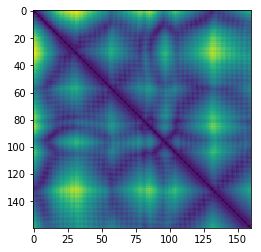

In [3]:
img_size = 160

BUFFER_SIZE = 60000
BATCH_SIZE = 64

regions = []
for i in range(len(train_df)):
    for j in range(seq_lengths[i] / img_size):
        regions.append(training_imgs['arr_'+str(i)][j*img_size:(j+1)*img_size, j*img_size:(j+1)*img_size])
regions = np.array(regions)
plt.imshow((255/regions[678].max()) * regions[678], aspect=1)
regions = np.tanh(regions.reshape((-1, img_size, img_size, 1))).astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices(regions).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
def get_generator(img_size):
    in_size = img_size / (2**4) # Transpose Convolution naturally upsamples 
    
    z = Input(shape = (100, ))
    x = Dense(256 * in_size * in_size, use_bias=False)(z)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Reshape([in_size, in_size, 256])(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), use_bias=False, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), use_bias=False, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv2DTranspose(32, (4, 4), strides=(2, 2), use_bias=False, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv2DTranspose(1, (4, 4), strides=(2, 2), use_bias=False, padding='same')(x)
    y = Activation('tanh')(x) # normalize output into [-1, 1]
    
    return Model(z, y)

def get_discriminator(img_size):
    img = Input(shape = (img_size, img_size, 1, ))
    
    x = Conv2D(32, (4, 4), strides=(2, 2), padding='same')(img)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Flatten()(x)
    y = Dense(1, use_bias=False)(x)
    
    return Model(img, y)

gen = get_generator(160)
gen.summary()

dis = get_discriminator(160)
dis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 25600)             2560000   
_________________________________________________________________
batch_normalization (BatchNo (None, 25600)             102400    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 25600)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25600)             0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 20, 20, 128)       524288    
__________

In [5]:
def gen_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

def dis_loss(real_output, generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
    total_loss = real_loss + generated_loss
    return total_loss

gen_optim = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5)
dis_optim = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5)

In [6]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optim,
                                 discriminator_optimizer=dis_optim,
                                 generator=gen,
                                 discriminator=dis)

In [7]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16
random_vector_for_generation = tf.random_normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [8]:
def train(dataset, epochs, noise_dim):  
    for epoch in range(epochs):
        start = time.time()

        for images in dataset:
            # generating noise from a uniform distribution
            noise = tf.random_normal([BATCH_SIZE, noise_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
                generated_images = gen(noise, training=True)

                real_output = dis(images, training=True)
                generated_output = dis(generated_images, training=True)

                gene_loss = gen_loss(generated_output)
                disc_loss = dis_loss(real_output, generated_output)

            gradients_of_gen = gen_tape.gradient(gene_loss, gen.variables)
            gradients_of_dis = dis_tape.gradient(disc_loss, dis.variables)

            gen_optim.apply_gradients(zip(gradients_of_gen, gen.variables))
            dis_optim.apply_gradients(zip(gradients_of_dis, dis.variables))

        if epoch % 1 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(gen, epoch + 1, random_vector_for_generation)

        # saving (checkpoint) the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(gen, epochs, random_vector_for_generation)

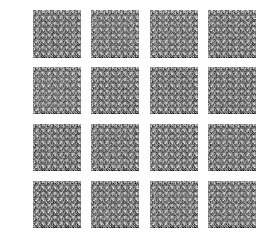

In [9]:
train(train_dataset, EPOCHS, noise_dim)